In [28]:
%%bigquery udf --module extract_tokens

function extract_topic(tokens){
    var trump = false, clinton = false;
    tokens.forEach(function(token){
      switch(token.content.toLowerCase()){
        case "trump" : 
        case "realdonaldtrump" :
        case "donald" :
          trump = true; break;
        case "hillary" :
        case "clinton" :
        case "hillaryclinton":
          clinton = true;break;          
      }
    })
    var topic = 'common';
    if(trump && !clinton)
      topic = 'trump';
    else if(clinton && !trump)
      topic = 'clinton';
    return topic;
}

/**
 * @param {{tweet_object: string, polarity: float, magnitude: float, syntax:string }} r
 * @param function({{topic : string, type: string, content:string}}) emitFn
 */
function(r, emitFn) {
  try{
    var tweet = JSON.parse(r.tweet_object);
    var tokens = JSON.parse(r.syntax);
    
    tokens.forEach(function(token){
      if(token.content !== "&amp" && token.content!== "#")
        emitFn({topic : topic, type : token.partOfSpeech, content : token.content.toLowerCase()})
    })
  }
  catch(e){
  }  
}


In [29]:
%%sql --module words

part_of_speech="NOUN"
total = 10;

SELECT content, count(*) as count FROM extract_tokens(SELECT * FROM [in-full-gear:Dataset1.debates_tweets] 
WHERE NOT REGEXP_MATCH(tweet_object, "GoogleJsonResponseException"))
WHERE type=$part_of_speech
GROUp BY content
ORDER BY count desc
LIMIT $total

In [30]:
import datalab.bigquery as bq
nouns =  bq.Query(words, udf=extract_tokens, part_of_speech="NOUN", total=12);

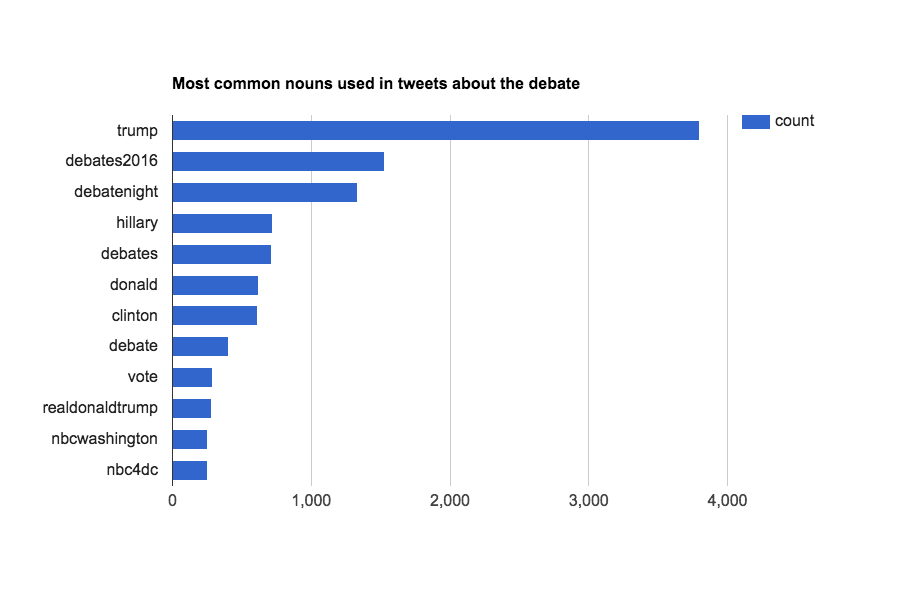

In [31]:
%%chart bars --data nouns
title: Most common nouns used in tweets about the debate
height: 600
width: 900

In [32]:
%%sql --module adjectives_by_topic

part_of_speech="ADJ"
total = 10;
topic = "common"

SELECT content, count(*) as count FROM extract_tokens(SELECT * FROM [in-full-gear:Dataset1.debates_tweets] 
WHERE NOT REGEXP_MATCH(tweet_object, "GoogleJsonResponseException"))
WHERE type=$part_of_speech AND topic=$topic
GROUp BY content
ORDER BY count desc
LIMIT $total

In [33]:
trump_adj =  bq.Query(adjectives_by_topic, udf=extract_tokens, topic="trump");

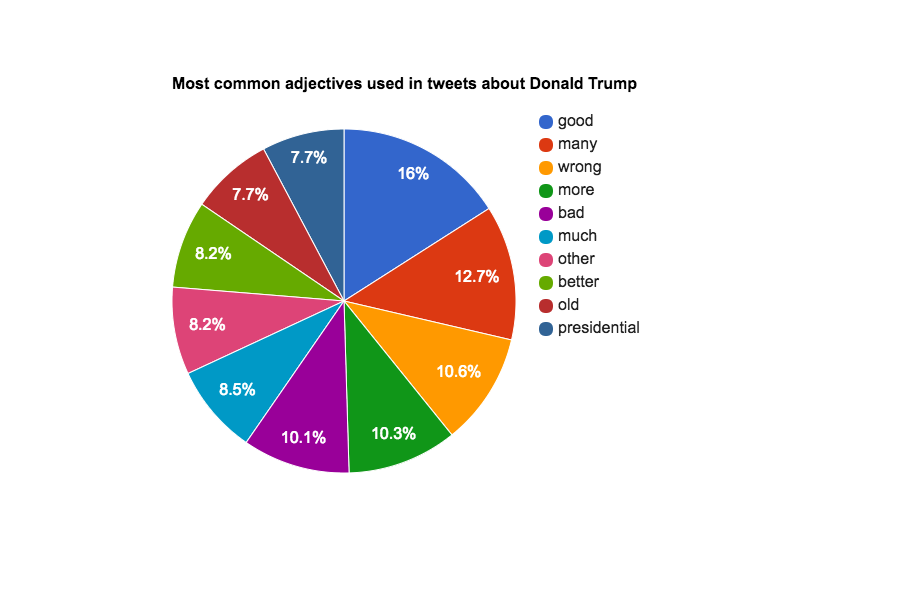

In [39]:
%%chart pie --data trump_adj
title: Most common adjectives used in tweets about Donald Trump
height: 600
width: 900
#colors: ["#E91D0E"]

In [36]:
clinton_adj =  bq.Query(adjectives_by_topic, udf=extract_tokens, topic="clinton");

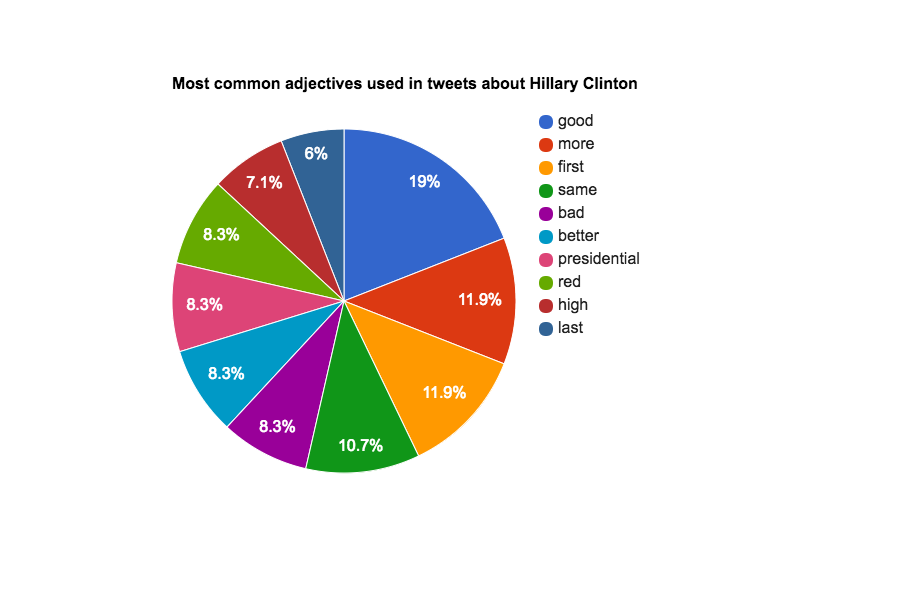

In [40]:
%%chart pie --data clinton_adj
title: Most common adjectives used in tweets about Hillary Clinton
height: 600
width: 900

In [49]:
%%bigquery udf --module extract_sentiment

function getStateName(placeName){
  return placeName.substring(placeName.indexOf(',') + 1).trim();
}

function extract_topic(tokens){
    var trump = false, clinton = false;
    tokens.forEach(function(token){
      switch(token.content.toLowerCase()){
        case "trump" : 
        case "realdonaldtrump" :
        case "donald" :
          trump = true; break;
        case "hillary" :
        case "clinton" :
        case "hillaryclinton":
          clinton = true;break;          
      }
    })
    var topic = 'common';
    if(trump && !clinton)
      topic = 'trump';
    else if(clinton && !trump)
      topic = 'clinton';
    return topic;
}

/**
 * @param {{tweet_object: string, polarity: float, magnitude: float, syntax:string }} r
 * @param function({{place:string, topic: string, polarity:float, magnitude:float}}) emitFn
 */
function(r, emitFn) {
  try{
    var tweet = JSON.parse(r.tweet_object);
    var tokens = JSON.parse(r.syntax);
    var topic = extract_topic(tokens);
    //emitFn({topic : topic, polarity: r.polarity, magnitude: r.magnitude, text : tweet.text});
    if(tweet && tweet.place && tweet.place.place_type==='city')
      emitFn({topic:topic, place : getStateName(tweet.place.full_name), polarity: r.polarity, magnitude: r.magnitude});
  }
  catch(e){
  }  
}

In [50]:
%%sql --module sentiment
topic = "trump"
SELECT polarity, magnitude FROM extract_sentiment(SELECT * FROM [in-full-gear:Dataset1.debates_tweets] 
WHERE NOT REGEXP_MATCH(tweet_object, "GoogleJsonResponseException"))
where topic = $topic

In [51]:
trump_sentiments =  bq.Query(sentiment, udf=extract_sentiment, topic="trump");

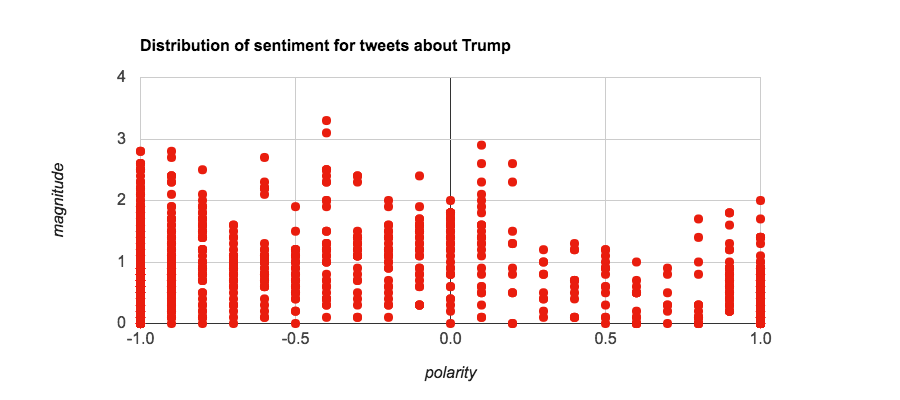

In [58]:
%%chart scatter --data trump_sentiments
title: Distribution of sentiment for tweets about Trump
height: 400
width: 900
legend : none  
hAxis:
  title: polarity
vAxis:
  title: magnitude
colors: ["E91D0E"]    

In [55]:
clinton_sentiments =  bq.Query(sentiment, udf=extract_sentiment, topic="clinton");

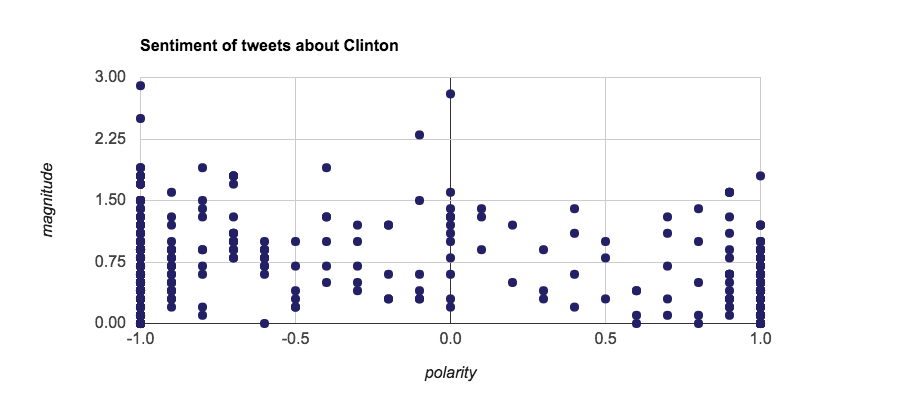

In [56]:
%%chart scatter --data clinton_sentiments
title: Distribution of sentiment for tweets about Clinton
height: 400
width: 900
legend : none  
hAxis:
  title: polarity
vAxis:
  title: magnitude
colors: ["#232066"] 